# Testing audio files for discrepancies between channels

As we have established, the audio files in our dataset are stereo — they were recorded using a stereo device (Sony IDC-TX800 recorder in 16 bit, 44.1 kHz stereo according to the ReCANVo article). We considered the idea of studying discrepancies between channels as a means to separate background noises from the actual vocalizations of interest. The intuitive idea is that the two microphones in the recorder should "hear" nearby sounds differently, since their source appears closer to one than the other, while the difference fades away for sounds from further away. In this notebook we test whether that approach is viable.

During data collection, the recorder was kept close to the participant. For this reason, if the presence of differences between channels is a good predictor of background noise, we should expect most files to display such differences. Instead, we will see that the left and right channels are identical for over 5,000 of the ~7,000 files in the dataset. This could be an indication that, while stereo functionality was available on the recorder, this feature may not have been used during data collection. For the other files, which for brevity we will call *true stereo*, we still want to better understand hese differences. To that end, we use different metrics to identify the few waveforms with the "largest" channel difference, and compare the channels themselves with their (sample-wise) sum and difference.

It should be noted that, even if our intuition is correct, a small difference between the channel should indicate that most of the recorded sound comes from far away, but if the difference is large then there could be a mix of close-by and far-away sounds. In other words, comparing channels might be a good way to identify which files are "pure far-away" sounds, but will fail to distinguish "pure close-by" sounds from mixtures of both, which is what we actually need. What is more, even though the two channels of a close-by sounds are not exactly identical, we should expect them to be largely similar, which means that replacing the channels with their sum and difference does not exactly separate background and foreground. What should still be true is that the difference between the channels should depend largely on the close-by components and only marginally, if at all, on the far-away part. In other words, what we can expect to arise from this analysis is at best some new features of the close-by components, but not a full noise removal strategy. In addition, since true stereo files are under 30% of the dataset, it may be difficult to use these features consistently, unless we observe strong correlations between "true-stereo-ness" and subsets of the data set we might want to study individually, e.g. specific participants.

We start by uploading the data from Google Drive.

In [1]:
! gdown 1e3ilpZosYjvGzjmO1Jaur6Ln4cJD8yAm
! tar -xf recanvo.tar.gz
! rm recanvo.tar.gz
! mv recanvo data

Downloading...
From (original): https://drive.google.com/uc?id=1e3ilpZosYjvGzjmO1Jaur6Ln4cJD8yAm
From (redirected): https://drive.google.com/uc?id=1e3ilpZosYjvGzjmO1Jaur6Ln4cJD8yAm&confirm=t&uuid=f98c71cf-3ec5-4cbd-95c1-f5ed4853e9bd
To: /content/recanvo.tar.gz
100% 1.06G/1.06G [00:23<00:00, 45.3MB/s]


Next we install the missing packages.

In [2]:
! pip install scikit-maad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 40.9 MB/s eta 0:00:00


Import libraries and tools.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from maad import sound, features, rois
from maad.util import power2dB, plot2d, format_features, overlay_rois
from IPython.display import Audio, display
from os import listdir

## Finding waveforms with distinct channels

We use a brute-force approach to locate true stereo files, i.e. those whose left and right channel are not identical. Namely, we scan the files and for each we annotate the maximum sample-by-sample absolute difference beween the two channels. If there is any difference at all between the two channels, this quantity will be non-zero. As a benchmark to decide when this quantity is "small", we also take note of the maximum amplitude within each file. We store the results across all files in two arrays `diffs` and `maxima`.

In [69]:
data_loc = "data/wav/"
filenames = listdir(data_loc)
diffs = np.zeros(len(filenames))
maxima = np.zeros(len(filenames))
for i, filename in enumerate(filenames):
  sl, _ = sound.load(data_loc + filename)
  sr, _ = sound.load(data_loc + filename, channel='right')
  diffs[i] = abs(sl-sr).max()
  maxima[i] = max(abs(sl).max(), abs(sr).max())

In [38]:
nonzero_diffs = np.count_nonzero(diffs)
nonzero_diffs

1937

In [39]:
print(diffs.max(), maxima.max(), (diffs/maxima).max())

1.9814387436598921 1.0022749052972193 1.9807671553076212


So we see that there are just about 2,000 true stereo files, and the maximum difference can be as large as twice the maximum amplitude, even within a single file. Let us plot the sorted maximum difference values.

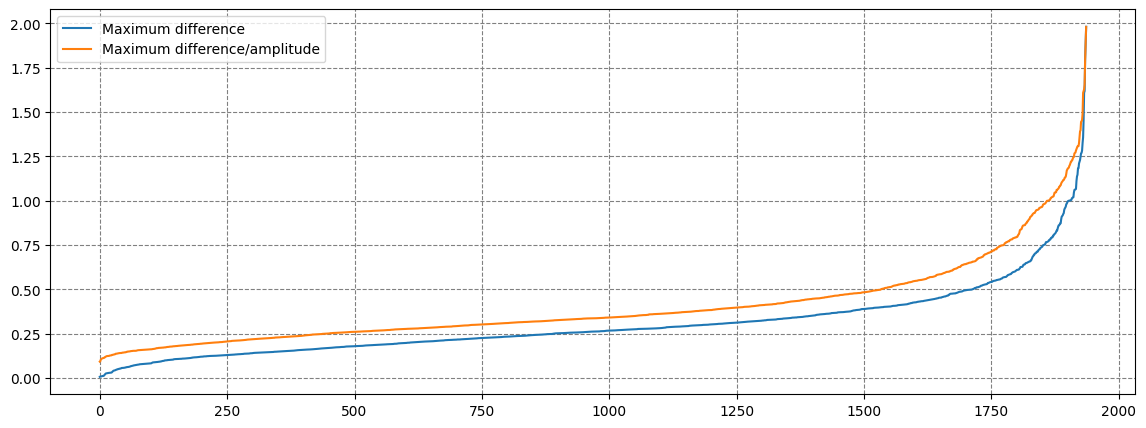

In [40]:
fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(1,1,1)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.plot([i for i in range(nonzero_diffs)], np.sort(diffs)[-nonzero_diffs:], label='Maximum difference')
plt.plot([i for i in range(nonzero_diffs)], np.sort(diffs/maxima)[-nonzero_diffs:], label='Maximum difference/amplitude')
plt.legend()
plt.show()

It appears that files with very large differences are rather exceptional. However, differences within a 25-50% range relative to the maximum amplitude appear to be quite common.

It would be tempting now to open a few files within different ranges of difference between channels and listen for background vs. foreground sounds. Before we do that, it is good to note the limitations of the metric we are currently using. While this maximum difference is great for detecting if the two channels are identical, a non-zero value will occur as soon as they differ at even just one time step. The maximum difference does not tell us whether the two channels are completely different waveforms or if they only differ at a few or even just one time step, something which might have been caused by a simple error.

In [87]:
# Restrict the `filenames` list to true stereo files and sort them
# by difference. The sorting is done in *decreasing* order.

sorted_indices = np.argsort(diffs)[-1:-nonzero_diffs-1:-1]
filenames = [filenames[i] for i in sorted_indices]
maxima = np.array([maxima[i] for i in sorted_indices])
diffs = np.array([diffs[i] for i in sorted_indices])

In [ ]:
# Open a few of the files with the largest difference and listen.

for i in range(5):
  filepath = data_loc + filenames[i]
  print(i, filenames[i])
  display(Audio(filepath))

These first few sounds are rather noisy (and some of them quite difficult to identify...), but it sounds like the source of noise might be some tampering with the recorder itself. Let us try listening to the two channels separately, as well as the sum and difference waveforms, for comparison.

In [10]:
def channels_sum_diff(file):
  sl, fs = sound.load(file)
  sr, _ = sound.load(file, channel='right')
  display(Audio(sl, rate=fs))
  display(Audio(sr, rate=fs))
  display(Audio(sl+sr, rate=fs))
  display(Audio(sl-sr, rate=fs))

In [ ]:
for i in range(5):
  filepath = data_loc + filenames[i]
  print(i, filenames[i])
  channels_sum_diff(filepath)

There is indeed some audible difference between the four versions of each file. In several cases, the noise seems to be more audible than the vocalization in the last version of each (difference between channels), which is compatible with the impression that the noise is coming from tampering with the recorder.

Let us try again with a few sounds with lower ratios.

In [ ]:
for i in range(90, 95):
  filepath = data_loc + filenames[i]
  print(i, filenames[i])
  channels_sum_diff(filepath)

In most of the cases in the range 90-94, the difference between the four versions is barely audible. In some cases, one channel sounds ever so slightly more crisp than the other, which might very well be due to the positioning of the recorder or obstructions around it.

Somewhat interestingly, in file number 93 (210111_1844_00-06-43.87--00-06-45.32c.wav) a soft thud can be heard at the very beginning in the right channel, but not the left — this persists in the difference.

In [ ]:
for i in range(400, 405):
  filepath = data_loc + filenames[i]
  print(i, filenames[i])
  channels_sum_diff(filepath)

We can also plot the waveforms to see if any clear differences are present.

In [14]:
def plot_waveforms(
    file,
    snip=None,
    show_left=True,
    show_right=True,
    show_diff=False,
    show_sum=False,
    linewidth=0.1,
  ):
  if isinstance(file, int):
    file = filenames[file]
  filepath = data_loc + file
  sl, _ = sound.load(filepath)
  sr, _ = sound.load(filepath, channel='right')
  if snip is not None:
    sl = sl[snip[0]:snip[1]]
    sr = sr[snip[0]:snip[1]]
  plt.figure(figsize=(14,5))
  if show_left:
    plt.plot([i for i in range(sr.shape[0])], sl, c='b', linewidth=linewidth)
  if show_right:
    plt.plot([i for i in range(sl.shape[0])], sr, c='r', linewidth=linewidth)
  if show_diff:
    plt.plot([i for i in range(sl.shape[0])], sl-sr, c='y', linewidth=linewidth)
  if show_sum:
    plt.plot([i for i in range(sl.shape[0])], sl+sr, c='m', linewidth=linewidth)
  plt.show()

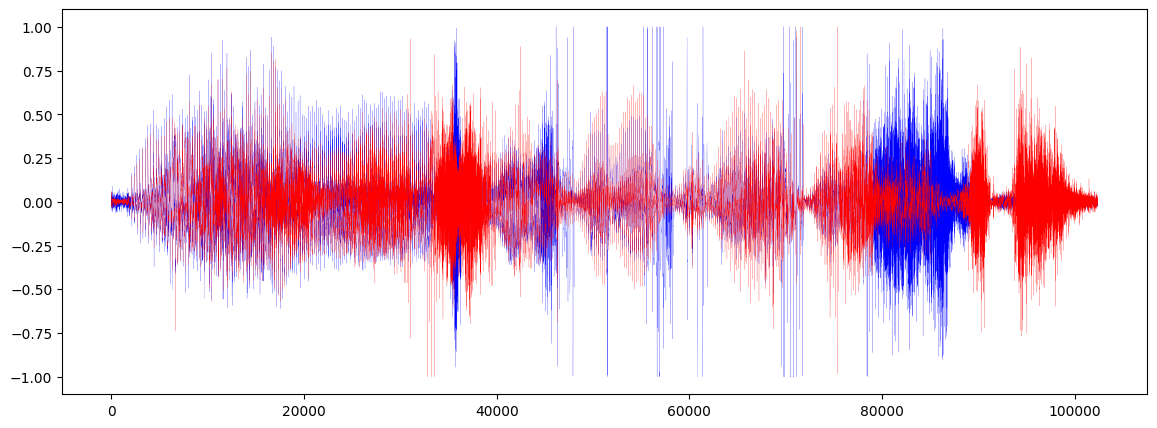

In [15]:
plot_waveforms(3)

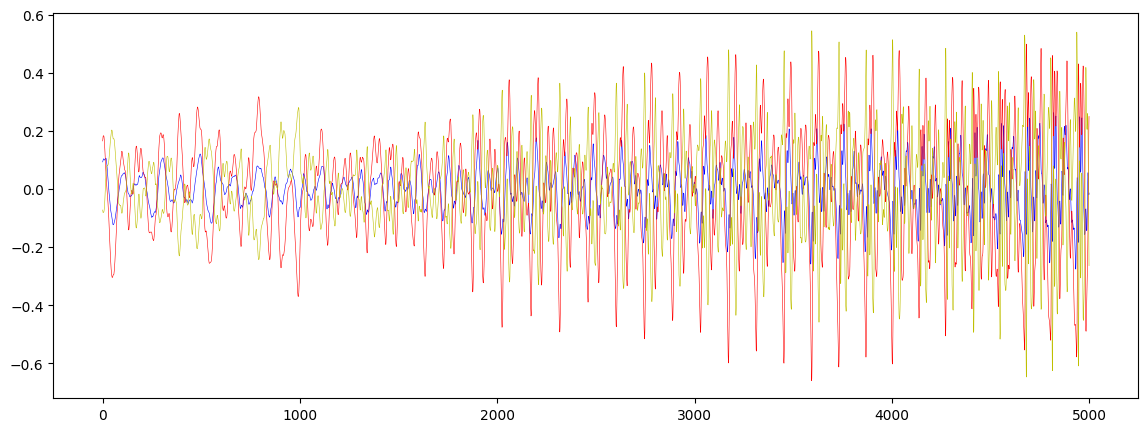

In [16]:
plot_waveforms(93, snip=(0, 5000), linewidth=.4, show_diff=True)

## Cosine similarity

As we noted before, the maximum difference between two channels can be large even though the signals are essentially identical, e.g. if they differ at just one sample. In order to quantify how fundamentally different two channels are we need to give more weight to differences that are more consistent across the whole waveform or at least extended in time. One way about this could be to take the *mean* absolute (or square) difference between the two channels over the whole interval. This way, localized differences lose importance in the averaging process, while consistent albeit possibly small differences carry more weight.

One way that two signals can be different as waveforms but represent essentially the same sound is if they differ by an overall scaling factor, which essentially amounts to volume. Thinking of the signals geometrically as vectors in Euclidean space, this translates in the vectors being alined, and one way to measure whether they are is to look at the cosine of the angle between them, which can be computed simply by a dot product. Let us try this.

In [17]:
from numpy import dot
from numpy.linalg import norm

In [82]:
def cos_sim(sig1, sig2):
  return (dot(sig1,sig2))/(norm(sig1)*norm(sig2))

In [83]:
def channel_cos_sim(file):
  left, _ = sound.load(file)
  right, _ = sound.load(file, channel='right')
  return cos_sim(left, right)

In [84]:
cosine_similarities = np.array([channel_cos_sim(data_loc+file) for file in filenames])

Let us plot these new data next to the maximum difference — the files are still sorted by that feature.

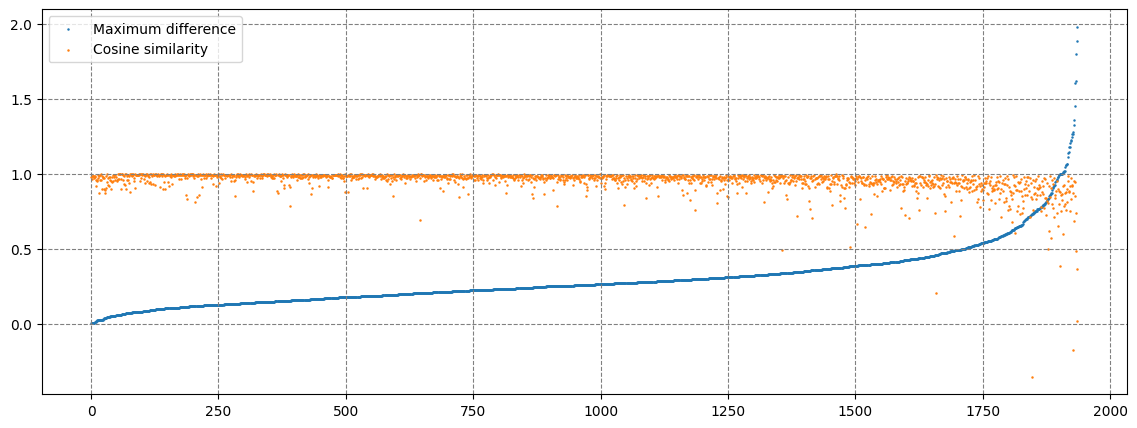

In [85]:
fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(1,1,1)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.scatter([i for i in range(nonzero_diffs)], diffs[::-1], s=.6, label='Maximum difference')
# plt.scatter([i for i in range(nonzero_diffs)], (diffs/maxima)[::-1], s=.3, label='Maximum difference/amplitude')
plt.scatter([i for i in range(nonzero_diffs)], cosine_similarities[::-1], s=.6, label='Cosine similarity')
plt.legend()
plt.show()

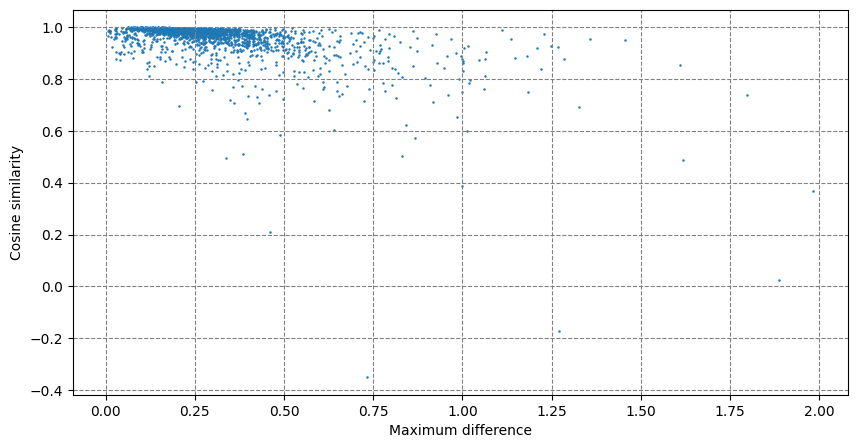

In [86]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1,1,1)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.scatter(diffs[::-1], cosine_similarities[::-1], s=.6)
plt.xlabel('Maximum difference')
plt.ylabel('Cosine similarity')
plt.show()

We see that cosine similarity values stay somewhat consistently close to 1 for most recordigns, but they tend to get more erratic as the maximum difference itself increases. This is consistent with our previous observations: for files in the 90-94 and 400-404 ranges (again, sorted in decreasing order by maximum difference) it was clear by listening separately to the two channels and their sum and diifference that all four "version" sounded very similar. This suggests that there is indeed a difference in the two channels, but they strongly "correlate" with each other, which is relfected in a large cosine similarity.

We also listened to the five recordings with the highest maximum difference earlier, and noticed that they are hardly identifyable and feature a significant amount of noise coming from tampering with the recorder. Those five recordings are very clearly identifyable in the last plot — they are represented by the five right-most points. Listening again to the second recording (corresponding to index 1), it is unsurprising that it has low (in fact, near-zero) cosine similarity, since of all the sounds we listened to it is the one with the most noticeable differences amongst its four versions.

In [ ]:
channels_sum_diff(data_loc+filenames[1])

For completeness, let us sort the recordings again by cosine similarity (in *increasing* order this time) and listen to some of those cosine similarity in the lowest, mid-low, and middle ranges.

In [89]:
sorted_indices = np.argsort(cosine_similarities)
filenames = [filenames[i] for i in sorted_indices]
maxima = np.array([maxima[i] for i in sorted_indices])
diffs = np.array([diffs[i] for i in sorted_indices])
cosine_similarities = np.array([cosine_similarities[i] for i in sorted_indices])


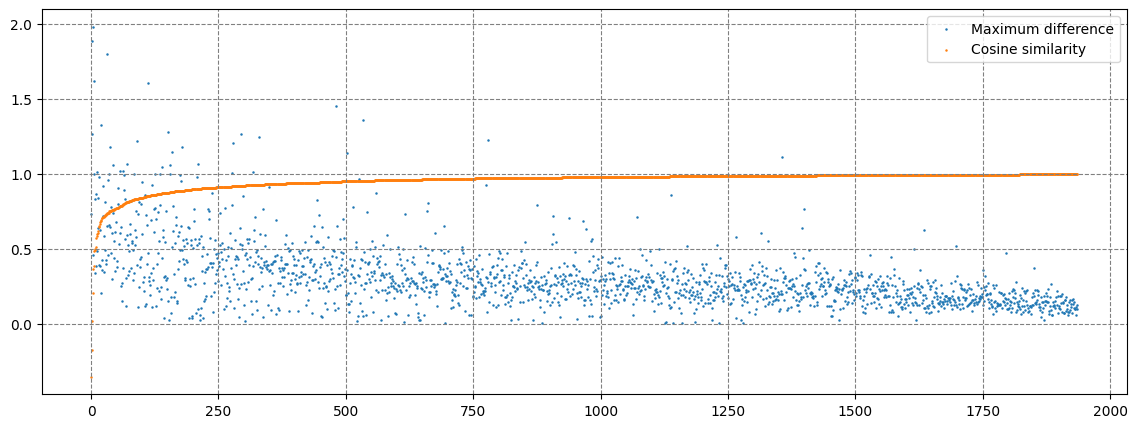

In [94]:
fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(1,1,1)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.scatter([i for i in range(nonzero_diffs)], diffs, s=.6, label='Maximum difference')
# plt.scatter([i for i in range(nonzero_diffs)], (diffs/maxima), s=.3, label='Maximum difference/amplitude')
plt.scatter([i for i in range(nonzero_diffs)], cosine_similarities, s=.6, label='Cosine similarity')
plt.legend()
plt.show()

The five recordings with the lowest similarity correspond to the five lowest points in the maximum difference vs. cosine similarity scatter plot. Unsurprisingly, some of the sounds below are the same we already heard during maximum difference analysis (as could be seen in the scatter plot).

In [ ]:
for i in range(5):
  filepath = data_loc + filenames[i]
  print(i, filenames[i])
  channels_sum_diff(filepath)

In [ ]:
for i in range(5, 10):
  filepath = data_loc + filenames[i]
  print(i, filenames[i])
  channels_sum_diff(filepath)

 One can notice that the difference for the second sound (index 1) is more distinct than for the first (index 0). This is consistent with the fact that their respective cosine similarities are *negative*, and a "more negative" value means greater similarity.

 Overall, no far-away noise is clearly audible in any of these low-cosine-similarity recordings, which makes sense. There are a few instances of thuds, tapping, or scratching on the recorder, and these are typically the only discernible differences between the two channels (other than possibly "crispness" of the sound).

The 40-60 range seems to correspond to cosine similarity of about .75 (which is roughly a 45-degree angle).

In [ ]:
for i in range(50, 55):
  filepath = data_loc + filenames[i]
  print(i, filenames[i])
  channels_sum_diff(filepath)

In [ ]:
for i in range(200, 205):
  filepath = data_loc + filenames[i]
  print(i, filenames[i])
  channels_sum_diff(filepath)

Notice that sound 204 (210216_1105_00-04-08.76--00-04-09.57c.wav) contains some overlapping speech, which is somewhat attenuated in the difference version.

In [ ]:
for i in range(750, 755):
  filepath = data_loc + filenames[i]
  print(i, filenames[i])
  channels_sum_diff(filepath)

## Conclusions

Overall, it seems that comparing and manipulating channels is not a good way to detect or eliminate background noise. Only a fraction of under 30% of files have any differences at all between the channels, and even where a difference does occur and is most pronounced there appears to be no strong correlation with "far away" noises. In some cases, the sample-wise difference between channels does seem to pick out some noises originating from direct interaction with the recorder itself, and it is conceivable that some form of further elaboration might lead to some cleaning of such noises. However, since the channel difference does not appear in the entire dataset, it is probably not a good idea to attempt this.

In the cases considered in the notebook, the two channels, their sum, and their difference, appear to all represent very similar sounds, although some amount of normalization is likely happening behind the curtains when the sounds are played. At any rate, this suggests that using the two channels separately, or linear combinations of them, might be an effective method for data augmentation. Again, caution should probably be used since this is not possible on the entire data set.

It is also reasonable that there might be a correlation between the stereo feature and the participant or session. This is probably an easy check, and if that is the case, then the ideas suggested above might be safely applicable for training models for specific participants.